## step1: Importing Libraries and Data

In [27]:

# importing libraries
import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow.keras import layers, models 
import matplotlib.pyplot as plt 

In [28]:

IMAGE_SIZE = 256
BATCH_SIZE = 32

In [8]:
import zipfile
import os

# Path to the ZIP file and target extraction folder
zip_path = "PotatoCheck.zip"
extract_path = "PlantVillage_Potato"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Folder extracted successfully!")


Folder extracted successfully!


In [29]:
# importing dataset directory 
df = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage_Potato",shuffle=True,image_size= (IMAGE_SIZE,IMAGE_SIZE),
                                                        batch_size= BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [30]:
class_names = df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [31]:
# len of dataset ( Total number of files/ batch size)
len(df)

68

In [33]:
print(df)

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Step2: Showing the Data Images

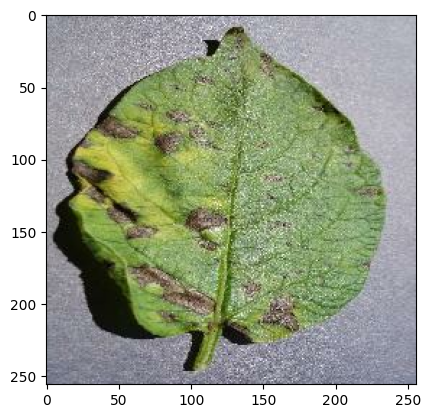

In [34]:

# showing image 
for image_batch, label_batch in df.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    
  

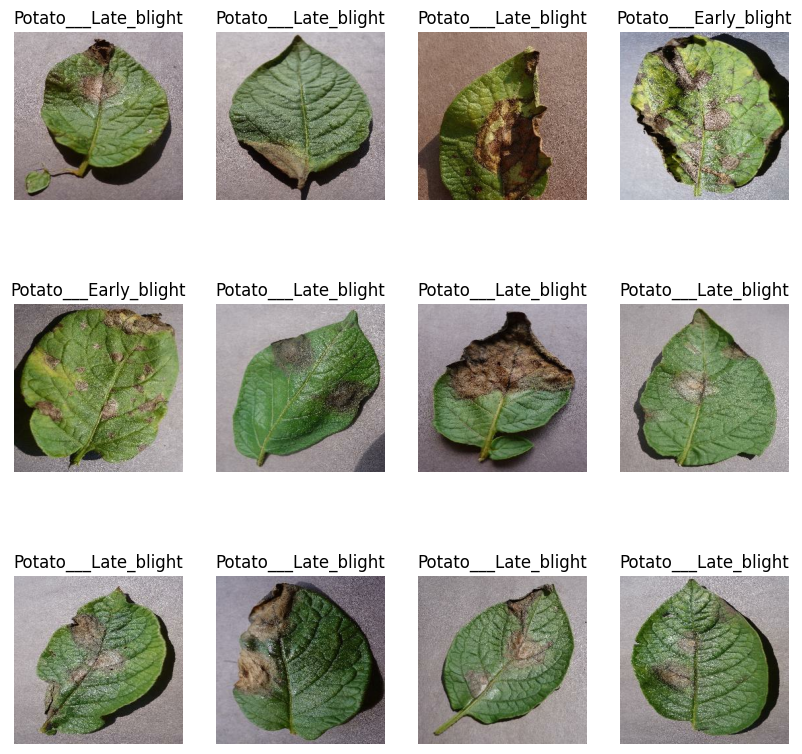

In [35]:
# images with the labels
plt.figure(figsize=(10,10))
for image_batch, label_batch in df.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
        

## Step3: Splitting Dataset

## Training , Validation and Testing

In [36]:
# channels (RGB[Red, Green, Blue]), Epochs = 50
CHANNELS = 3
EPOCHS = 50

In [37]:
train_size = 0.8
len(df) * train_size

54.400000000000006

In [38]:
# length of validation and test data
val_n_test = len(df) - (len(df) * train_size)
val_n_test

13.599999999999994

In [39]:
# splitting the data into training , validation and testing data

def split_datasets(pc,train_split = 0.8,val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    if shuffle:
        pc = pc.shuffle(shuffle_size,seed = 10)
        
    pc_size = len(pc) # size of potato_data(68)
    train_size = int(train_split*pc_size)
    val_size = int(val_split*pc_size)
    
    train_pc = pc.take(train_size) # taking first 54 batches(out of 68)
    val_pc = pc.skip(train_size).take(val_size) # leaving first 54 and taking next 6 batches
    test_pc = pc.skip(train_size).skip(val_size) # skipping first 54(train) batch and 6(validation) batch and 
                                                 #taking left 8 batches for test
    
    return train_pc, val_pc, test_pc

In [40]:

# getting the training, validation and testing data by 'split_datasets' function
train_data, val_data, test_data = split_datasets(df)

In [41]:

# printing the size of all data splits
print("Size of Data is :{0} \nBatch Size of Training Data is :{1} \nBatch Size of Validation Data :{2} \nBatch Size of Test Data :{3}"
      .format(len(df), len(train_data), len(val_data), len(test_data)))

Size of Data is :68 
Batch Size of Training Data is :54 
Batch Size of Validation Data :6 
Batch Size of Test Data :8


In [42]:
# caching, shuffling and prefetching the data
train_pc = train_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_pc = val_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_pc = test_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

## Step4: Data Pre-Processing

In [43]:
# Image Preprocessing : Rescaling and Resizing
rescale_n_resize = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augmentation by flipping and rotating existing images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode ='horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(factor=0.5)
])

## Step5: Model Building

In [44]:

# creating CNN
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    rescale_n_resize,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax')
    
])

model.build(input_shape=input_shape)

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [46]:
# optimizing the model
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

## Step6: Model Training and Analysis

In [49]:
history = model.fit(train_data, epochs = EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose=1)

Epoch 1/50
54/54 [==============================] - 99s 2s/step - loss: 1.3721 - accuracy: 0.4208 - val_loss: 0.9711 - val_accuracy: 0.4167
Epoch 2/50
54/54 [==============================] - 91s 2s/step - loss: 0.8948 - accuracy: 0.5098 - val_loss: 0.8797 - val_accuracy: 0.6302
Epoch 3/50
54/54 [==============================] - 90s 2s/step - loss: 0.8056 - accuracy: 0.6180 - val_loss: 0.7340 - val_accuracy: 0.6771
Epoch 4/50
54/54 [==============================] - 89s 2s/step - loss: 0.6399 - accuracy: 0.7406 - val_loss: 0.7330 - val_accuracy: 0.6875
Epoch 5/50
54/54 [==============================] - 88s 2s/step - loss: 0.4538 - accuracy: 0.8122 - val_loss: 0.4110 - val_accuracy: 0.8177
Epoch 6/50
54/54 [==============================] - 90s 2s/step - loss: 0.2946 - accuracy: 0.8819 - val_loss: 0.2419 - val_accuracy: 0.8958
Epoch 7/50
54/54 [==============================] - 87s 2s/step - loss: 0.3508 - accuracy: 0.8697 - val_loss: 0.3096 - val_accuracy: 0.8594
Epoch 8/50
54/54 [==

In [50]:
# evaluating the scores
scores = model.evaluate(train_data)
scores

54/54 [==============================] - 20s 351ms/step - loss: 0.0334 - accuracy: 0.9884


[0.03341037034988403, 0.9884259104728699]

In [51]:
# getting the keys of fitted model "History"
history.params, history.history.keys()

({'verbose': 1, 'epochs': 50, 'steps': 54},
 dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy']))

In [52]:
# assigning names to the keys
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

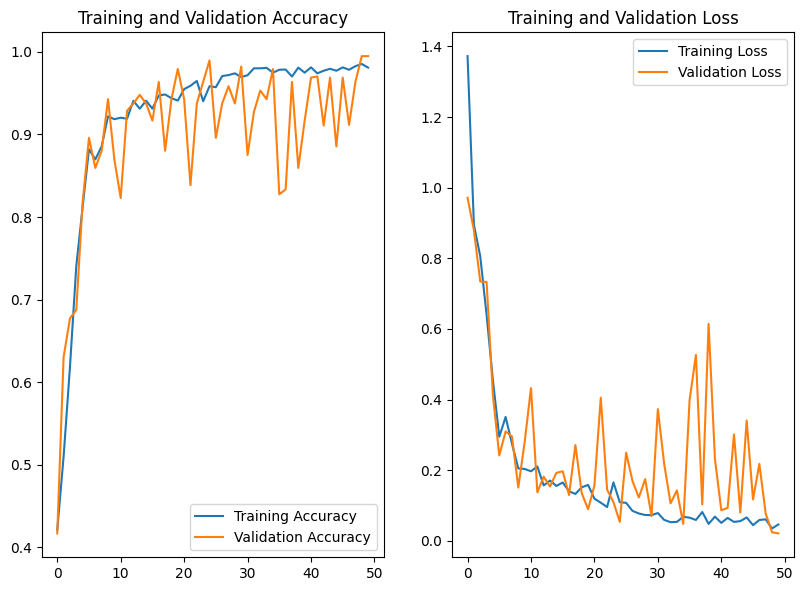

In [53]:
# plotting the comparison graphs
plt.figure(figsize = (15,15))

# Accuracy Table
plt.subplot(2,3,1)
plt.plot(range(EPOCHS),train_acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Table
plt.subplot(2,3,2)
plt.plot(range(EPOCHS),train_loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

## Step7: Validation on Test Data

1/1 [==============================] - 0s 359ms/step


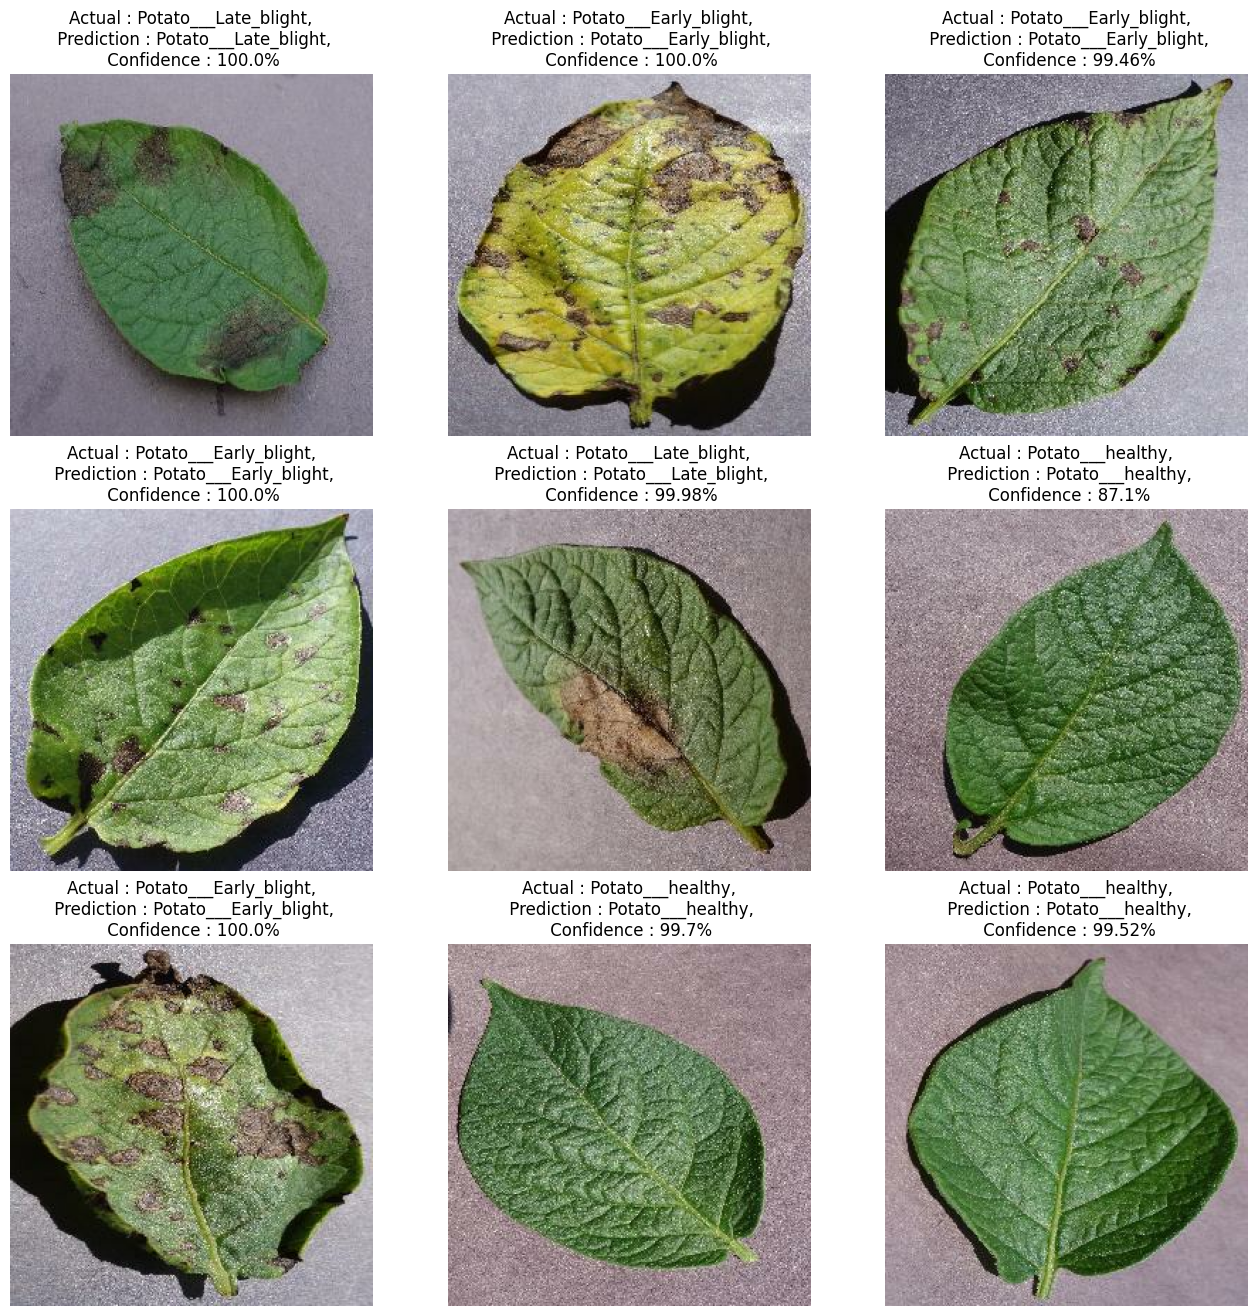

In [54]:
# plotting batch of test images with its actual label, predicted label and confidence
plt.figure(figsize = (16,16))
for batch_image, batch_label in test_pc.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_names[batch_label[i]]
    
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')

## Step8: Predicting on New Images

In [55]:
unk_lf = tf.keras.preprocessing.image_dataset_from_directory("Potato_Unknown_leaves",
                                                             image_size=(IMAGE_SIZE,IMAGE_SIZE))

Found 6 files belonging to 4 classes.


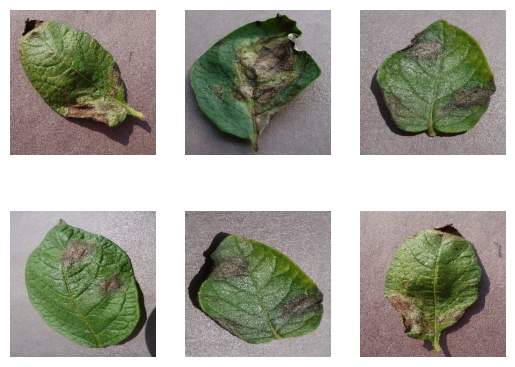

In [56]:
for image_batch, label_batch in unk_lf.take(1):
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")


1/1 [==============================] - 0s 68ms/step


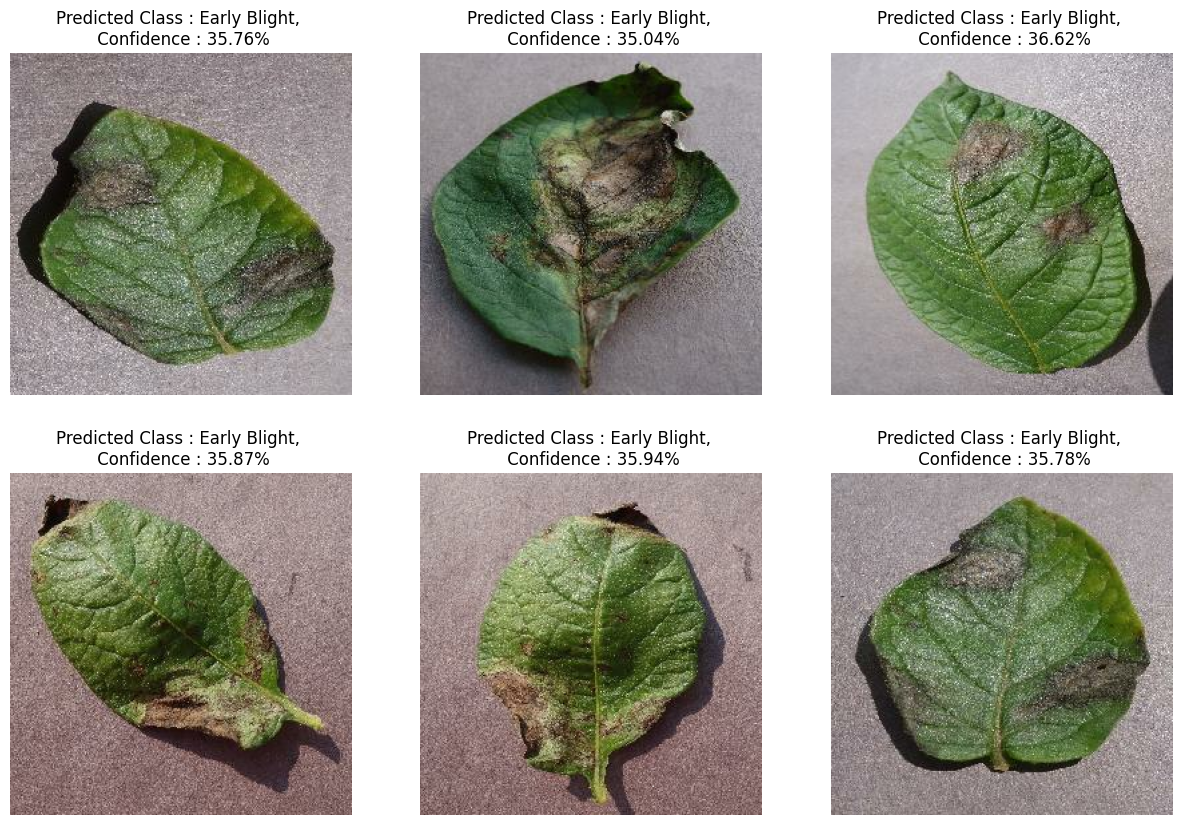

In [75]:
# predicting the class
plt.figure(figsize = (15,10))
for image_batch, label_batch in unk_lf.take(1):
    for i in range(6):
        ax = plt.subplot(2,3,i+1)
        image = image_batch[i].numpy().astype("uint8")
        label = class_names[label_batch[i]]
        
        plt.imshow(image)

                
        unk_lf_pred = model.predict(image_batch)
        pred_class = class_names[np.argmax(unk_lf_pred[i])]
        confidence = round(np.max(unk_lf_pred[i])*100, 2)
        
        plt.title(f'Predicted Class : {pred_class}, \n Confidence : {confidence}%')
        
        plt.axis("off")